# Fisher Analysis
In this notebook we explore the Fisher metric with quantized models.

In [1]:
%reload_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import ast
import os
import sys
from statistics import mean


# import modules from RN08 model
module_path = os.path.abspath(os.path.join('../../workspace/models/rn08/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import rn08

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import q_autoencoder as econ
import autoencoder_datamodule

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from fisher import FIT



## Utility methods

In [2]:
def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Greens',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, 
                cmap=cmap, 
                annot=show_value, 
                fmt=".2f", 
                vmin=min_max[0], 
                vmax=min_max[1],
                cbar_kws={'label': scale_label})

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()
    
def plot_fisher_trace_per_layer(value, 
                                title, 
                                x_label='Layers', 
                                y_label='Fisher trace'):
    plt.figure(figsize=(12,6))
    
    plt.bar(value.keys(), 
            value.values())

    plt.ylim(0, 1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Display the plot
    plt.show()

In [3]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# ECON model (Autoencoder)
we focus our analysis on the encoder which will be deploy on an ASIC.

In [4]:
DATA_PATH = '/data/tbaldi/work/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

size = 'baseline'
ECON_layers = ['encoder.conv', 'encoder.enc_dense']

precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]


In [5]:
def get_estimated_fisher(batch_size, 
                         learning_rate, 
                         precision,
                         size, 
                         dataloader,
                         min_it=100,
                         max_it=1000,
                         load=True):
    '''
    Get the value of the Fisher matrix
    '''
    
    # path to the directory
    path = os.path.join(
        DATA_PATH, 
        f'bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}/'
    )
    
    # load the model and the performance
    model, emd = econ.load_model(DATA_PATH, batch_size, learning_rate, precision, size)
    
    # instantiate the metric
    metric = FIT(model, 
                 dataloader, 
                 input_spec=(batch_size, 1, 8, 8),
                 target_layers=ECON_layers)
    
    # try to load the result
    if load:
        if metric.load_from_file(path):
            return metric.results
        else:
            print("Information not stored in ", path)
    
    # compute the result and store it
    result = metric.EF(min_iterations=min_it, max_iterations=max_it)
    metric.save_on_file(path=path)
    
    return result

## Results

Neural efficiency require to process an input sample per time. 

In [6]:
noise = 5 # 5 10 15 20
noise_type = 'gaussian'

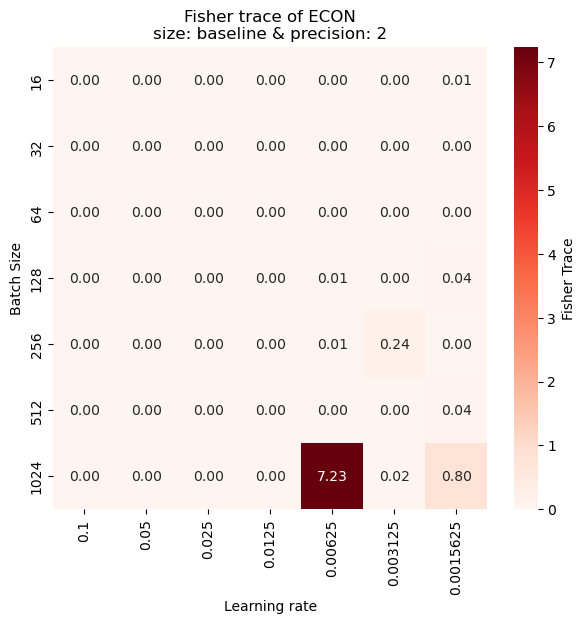

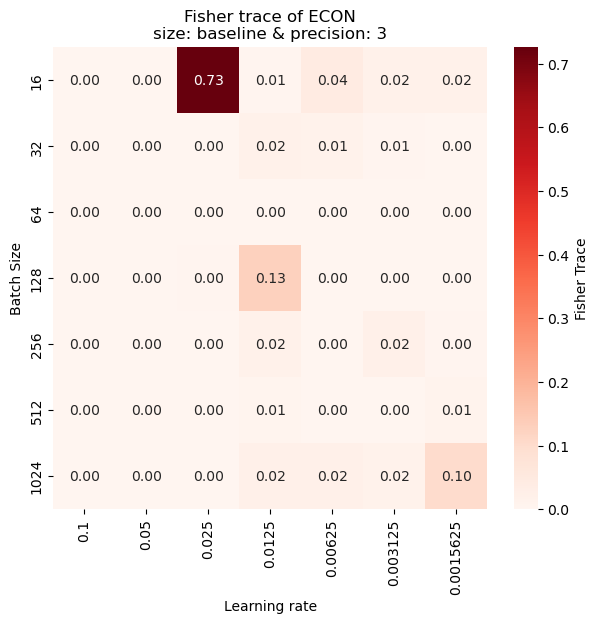

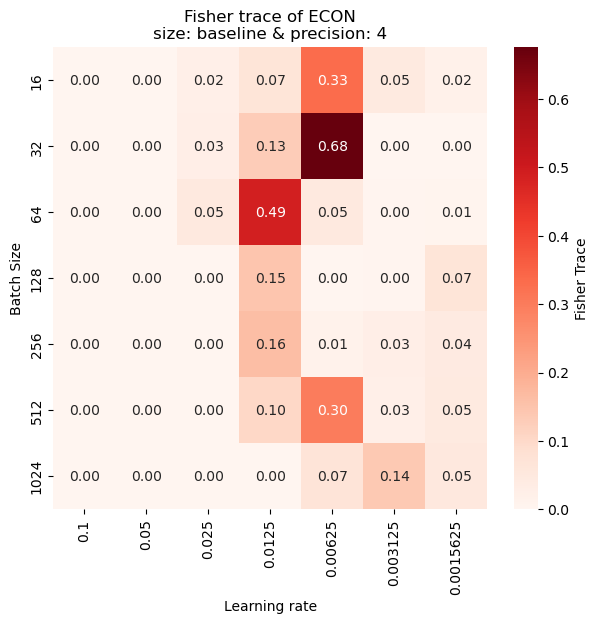

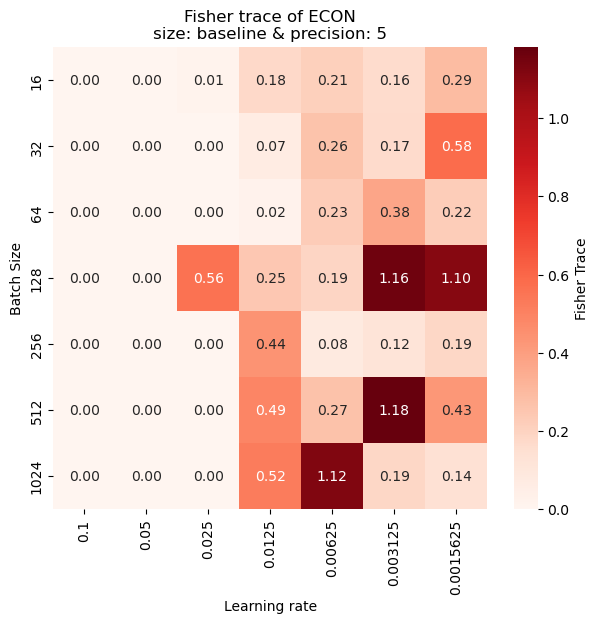

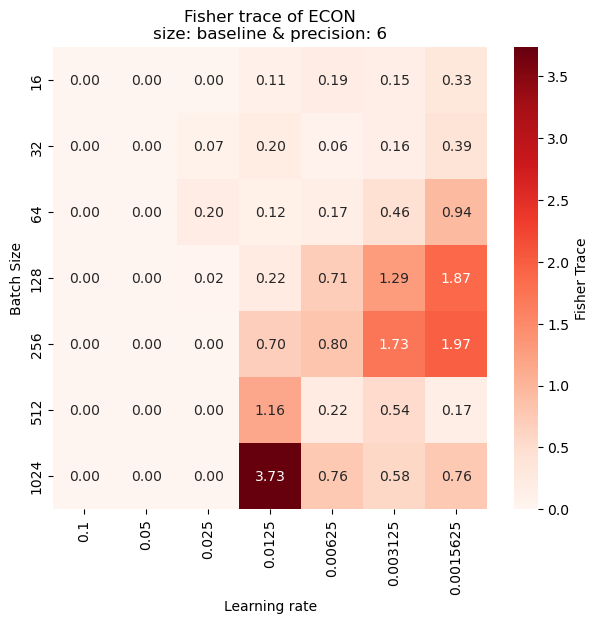

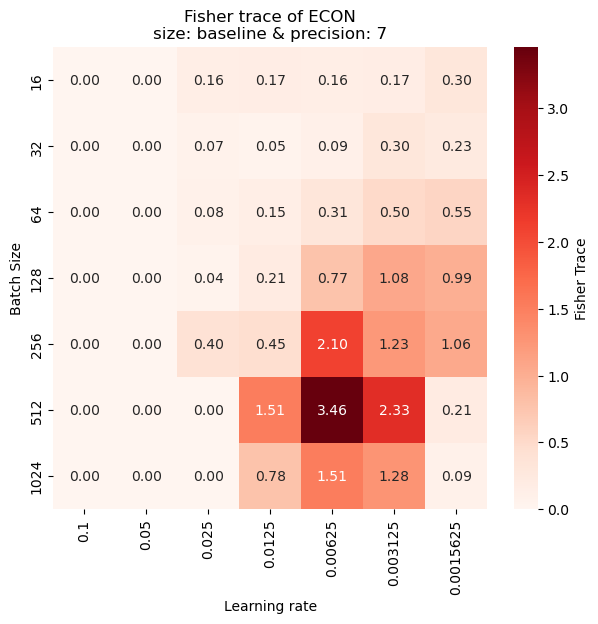

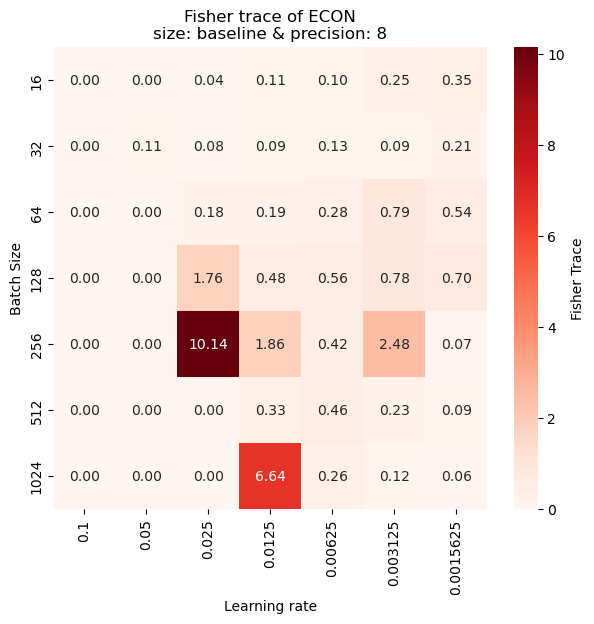

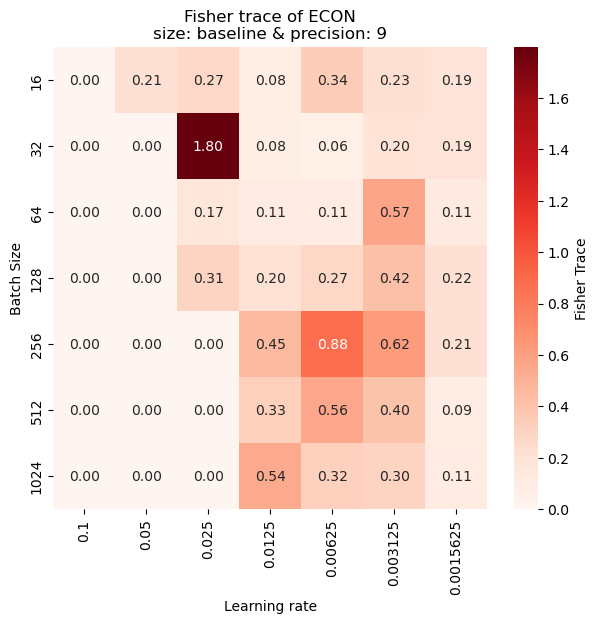

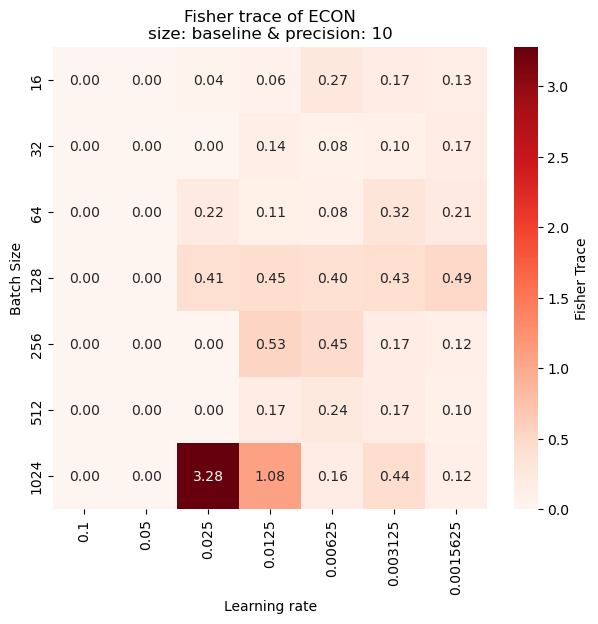

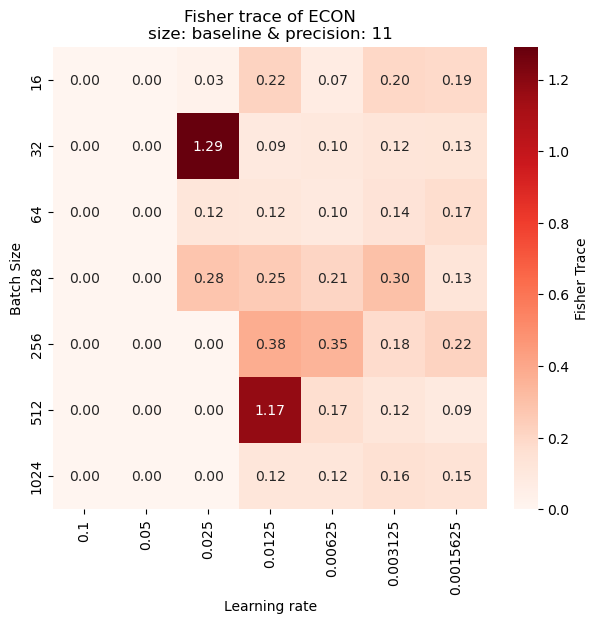

In [7]:
fisher_distribution = []
for p in precisions:
    fisher_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        fisher_dataloader = autoencoder_datamodule.get_data_module(DATASET_DIR, DATASET_FILE, bs)
        for y, lr in enumerate(learning_rates):
            
            # get the performances with and without noise
            mean_emd, _ = econ.get_model_index_and_relative_EMD(DATA_PATH, bs, lr, p, size)
            noise_emd = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, noise)
            
            # get the model
            model, emd = econ.load_model(DATA_PATH, bs, lr, p, size)
    
            # instantiate the metric
            metric = FIT(model, 
                        fisher_dataloader, 
                        input_spec=(bs, 1, 8, 8),
                        target_layers=ECON_layers)
            
            # load the value from the file
            path = os.path.join(
                DATA_PATH, 
                f'bs{bs}_lr{lr}/ECON_{p}b/{size}/'
            )
            result = -1
            if metric.load_from_file(path):
                result = sum(metric.results['EF_trace_w'])
            
            # build the heatmap matrix
            fisher_matrix[x, y] = result
            
            # build the dataframe for further analysis
            fisher_distribution.append({
                'precision': p, 
                'avg_EF': result,
                'emd': mean_emd,
                'noise_emd': noise_emd,
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (noise_emd - mean_emd) * 100 / mean_emd,
            })
            
    # plot the heatmaps per precision
    fisher_matrix = pd.DataFrame(fisher_matrix, 
                             index=batch_sizes, 
                             columns=learning_rates)
    plot_2d_heatmap(fisher_matrix, 
                    f'Fisher trace of ECON\nsize: {size} & precision: {p}', 
                    (0, fisher_matrix.max().max()),
                    'Learning rate',
                    'Batch Size',
                    'Fisher Trace',
                    cmap='Reds')
    

In [8]:
fisher_distribution_df = pd.DataFrame(fisher_distribution)
# eport to CSV
fisher_distribution_df.to_csv("./results/econ/fisher.csv", index=False)

# RN08 (ResNet)

In [9]:
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [10]:
DATA_PATH="/data/tbaldi/work/checkpoint/"   
DATASET_DIR = "/data/tbaldi/work/loss_landscape_taxonomy/data/RN08/"
RN08_layers = [
            'model.conv1', 
            'model.QBlocks.0.conv1', 
            'model.QBlocks.0.conv2', 
            'model.QBlocks.1.conv1', 
            'model.QBlocks.1.conv2',  
            'model.QBlocks.2.conv1', 
            'model.QBlocks.2.conv2',
            'model.QBlocks.2.shortcut',
            'model.QBlocks.3.conv1', 
            'model.QBlocks.3.conv2', 
            'model.QBlocks.4.conv1', 
            'model.QBlocks.4.conv2',
            'model.QBlocks.4.shortcut',
            'model.QBlocks.5.conv1', 
            'model.QBlocks.5.conv2', 
            'model.linear'
        ]
_, _, fisher_dataloader = rn08.get_cifar10_loaders(DATASET_DIR, 256)

Files already downloaded and verified


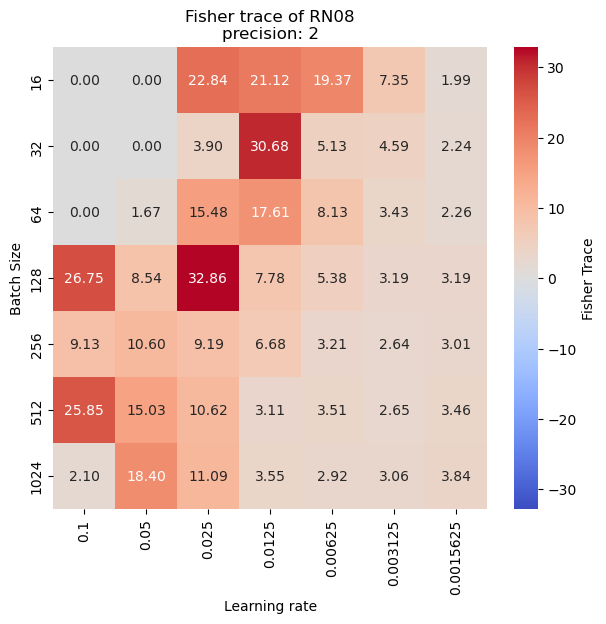

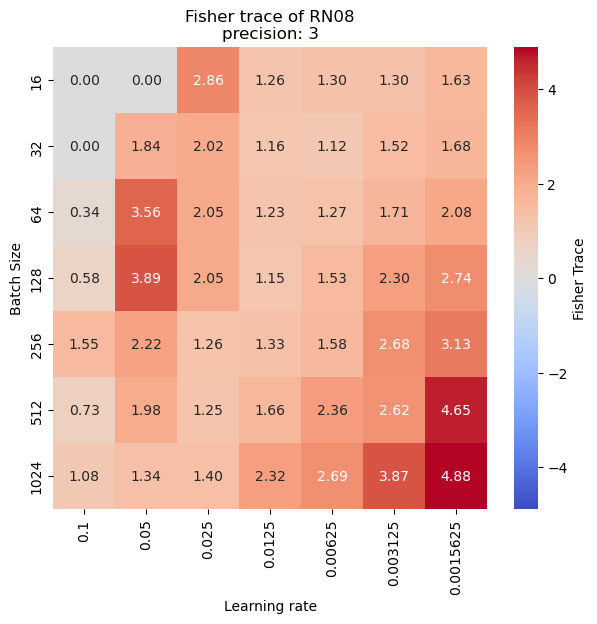

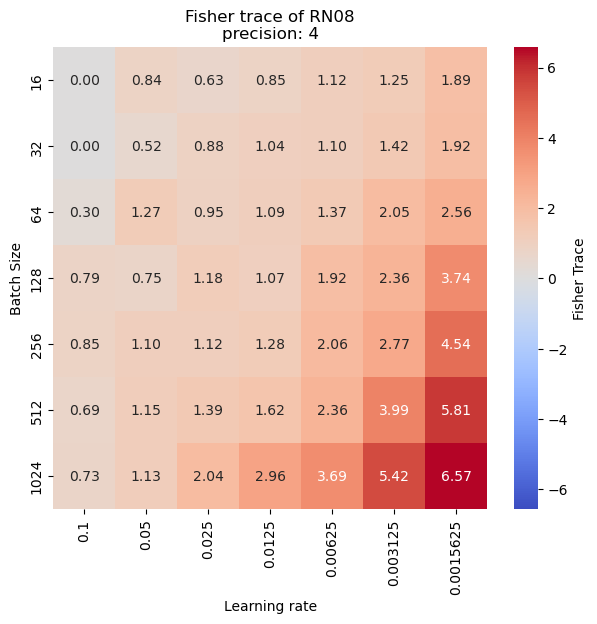

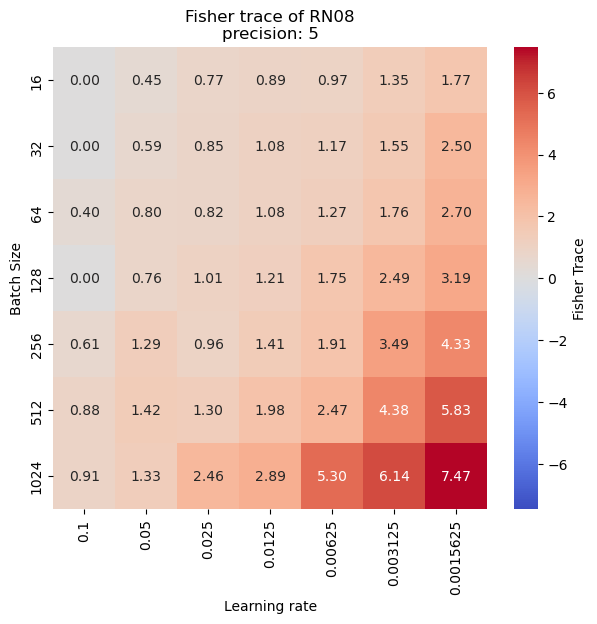

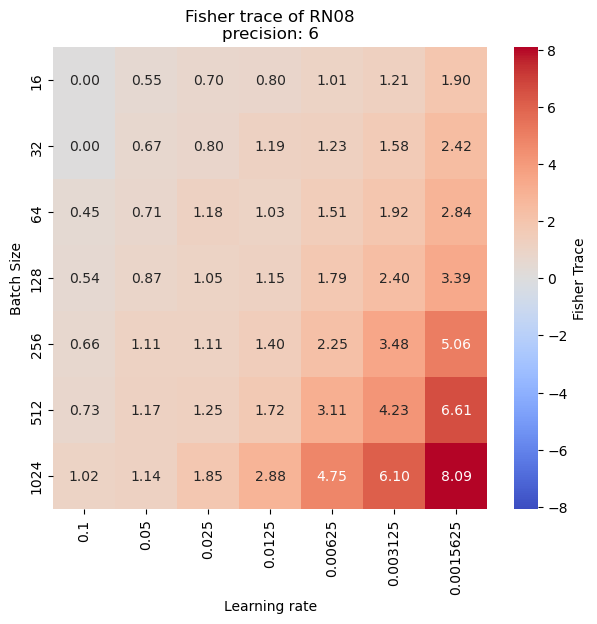

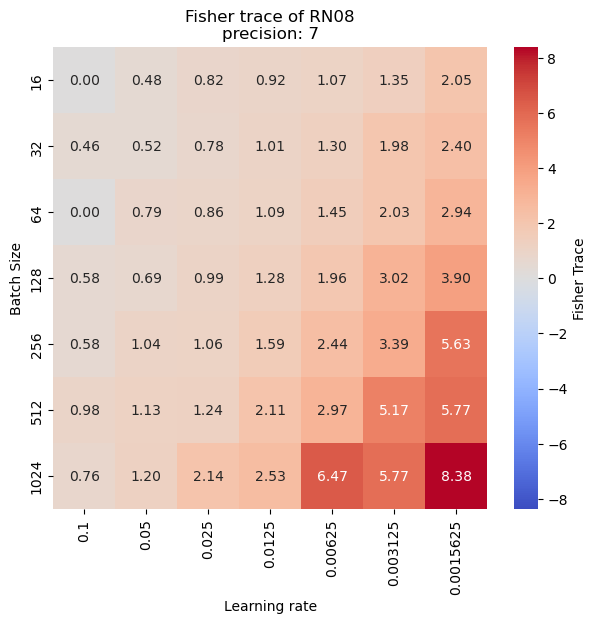

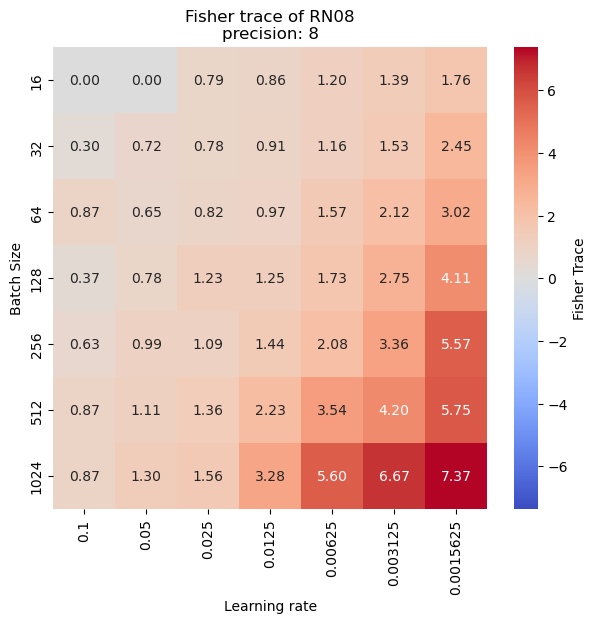

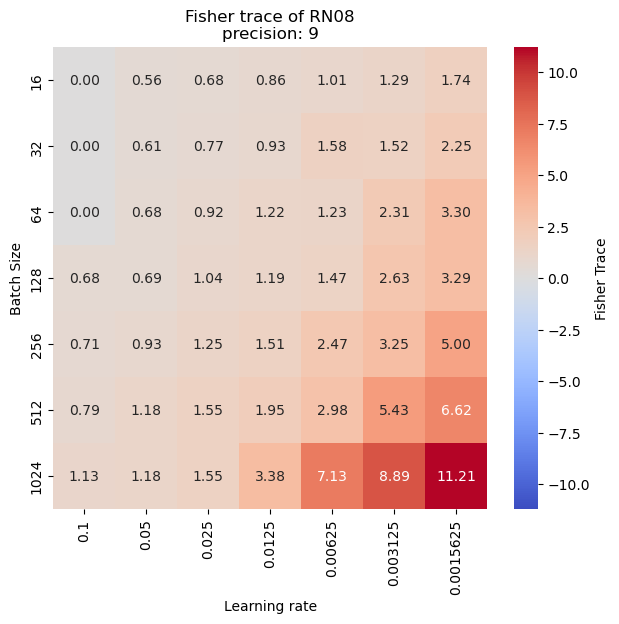

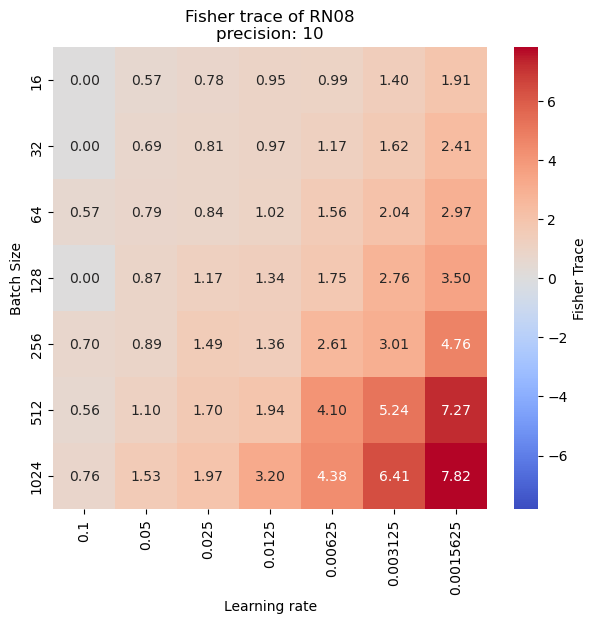

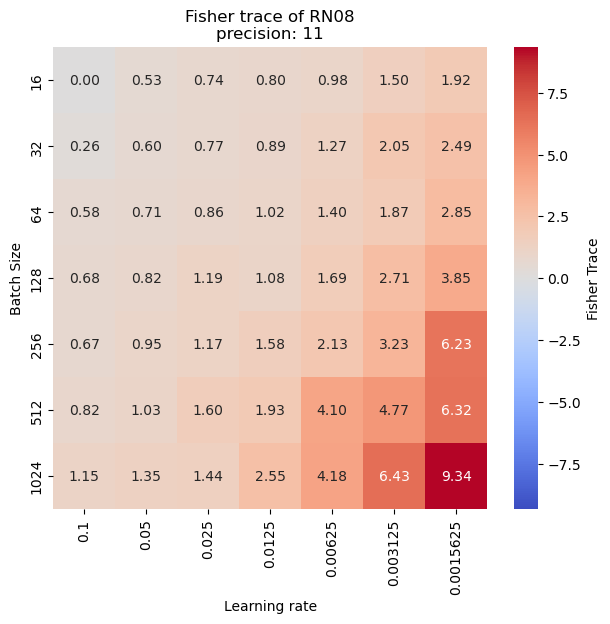

In [11]:
fisher_distribution = []
for p in precisions:
    fisher_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            
            try:
                # get the performances with and without noise
                model, acc = rn08.get_model_and_accuracy(DATA_PATH, bs, lr, p)
        
                # instantiate the metric
                metric = FIT(model, 
                            fisher_dataloader, 
                            input_spec=(bs, 3, 32, 32),
                            target_layers=RN08_layers)
                
                # load the value from the file
                path = os.path.join(
                    DATA_PATH, 
                    f'bs{bs}_lr{lr}/RN08_{p}b/'
                )
                result = -1
                if metric.load_from_file(path):
                    result = sum(metric.results['EF_trace_w'])
                
                # build the heatmap matrix
                fisher_matrix[x, y] = result
            except:
                fisher_matrix[x, y] = -1
            
            # build the dataframe for further analysis
            fisher_distribution.append({
                'precision': p, 
                'avg_EF': result,
                'accuracy': acc,
                'batch_size': str(bs),
                'learning_rate': str(lr),
            })
            
    # plot the heatmaps per precision
    fisher_matrix = pd.DataFrame(fisher_matrix, 
                             index=batch_sizes, 
                             columns=learning_rates)
    plot_2d_heatmap(np.cbrt(fisher_matrix), 
                    f'Fisher trace of RN08\nprecision: {p}', 
                    (-np.cbrt(fisher_matrix.max().max()), np.cbrt(fisher_matrix.max().max())),
                    'Learning rate',
                    'Batch Size',
                    'Fisher Trace',
                    cmap='coolwarm')
    

In [12]:
fisher_distribution_df = pd.DataFrame(fisher_distribution)
# export the CSV
fisher_distribution_df.to_csv("./results/rn08/fisher.csv", index=False)

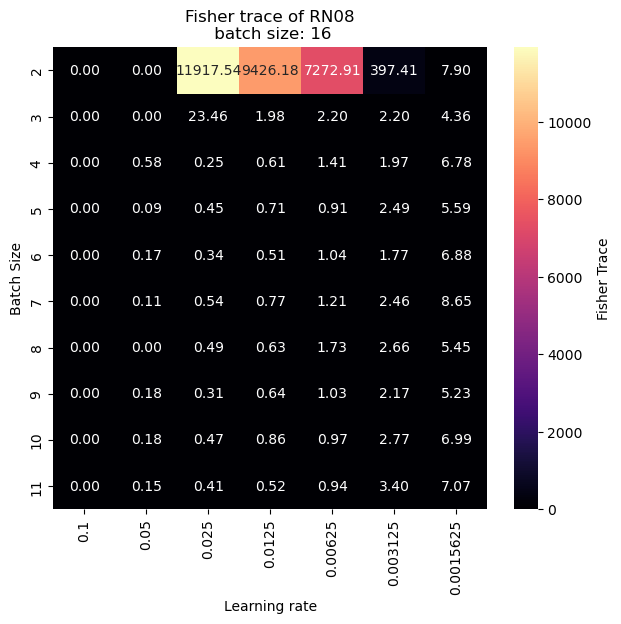

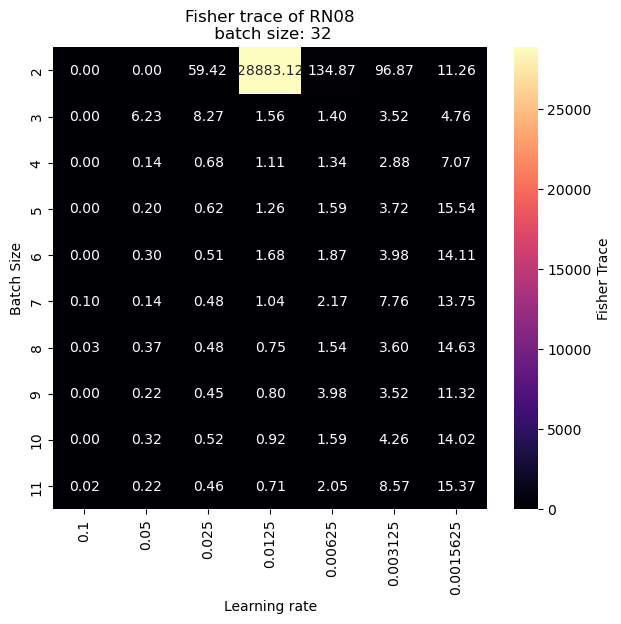

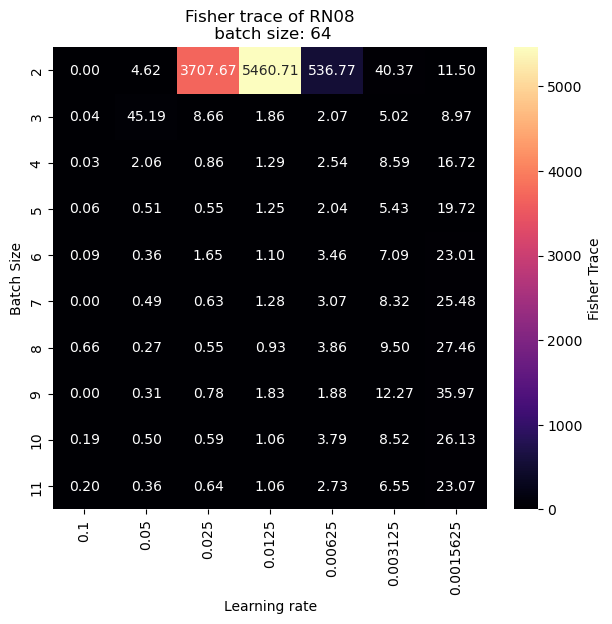

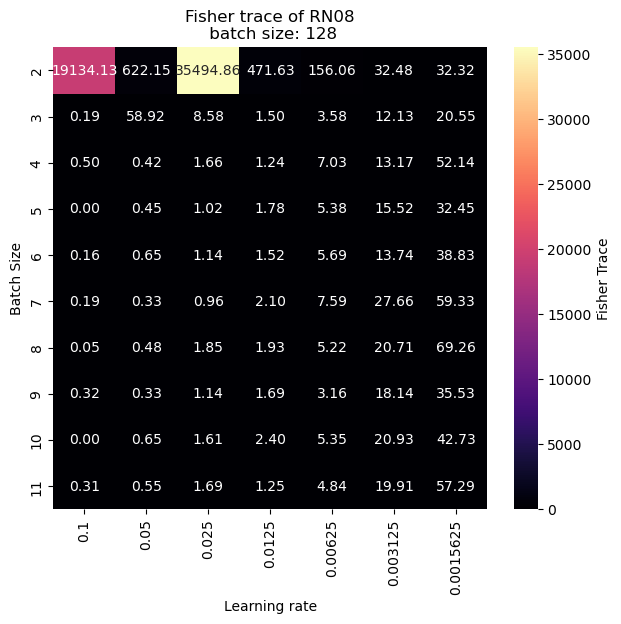

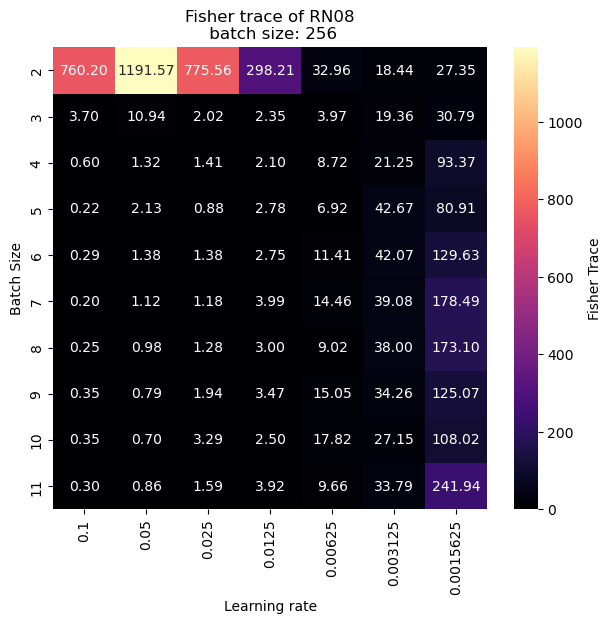

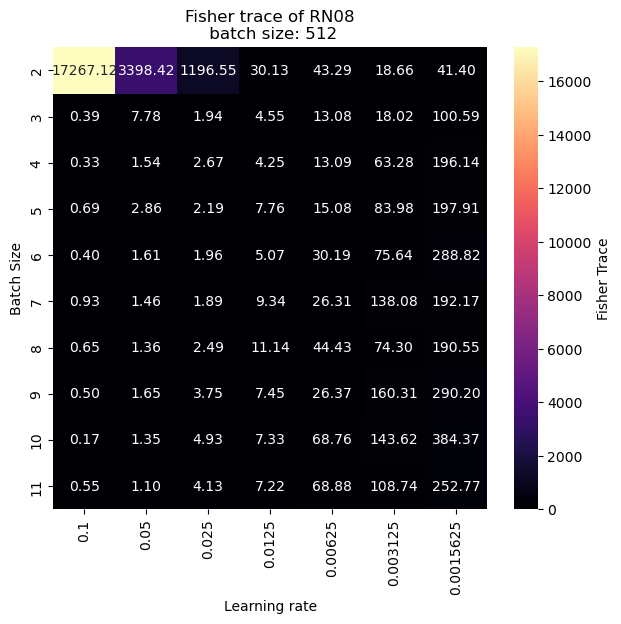

In [13]:
for bs in batch_sizes:
    fisher_matrix = np.zeros((len(precisions), len(learning_rates)))
    noise_matrix = np.zeros((len(precisions), len(learning_rates)))
    for y, lr in enumerate(learning_rates):
        for x, p in enumerate(precisions):
            try:
                # get the performances with and without noise
                model, acc = rn08.get_model_and_accuracy(DATA_PATH, bs, lr, p)
        
                # instantiate the metric
                metric = FIT(model, 
                            fisher_dataloader, 
                            input_spec=(bs, 3, 32, 32),
                            target_layers=RN08_layers)
                
                # load the value from the file
                path = os.path.join(
                    DATA_PATH, 
                    f'bs{bs}_lr{lr}/RN08_{p}b/'
                )
                result = -1
                if metric.load_from_file(path):
                    result = sum(metric.results['EF_trace_w'])
                
                # build the heatmap matrix
                fisher_matrix[x, y] = result
            except:
                fisher_matrix[x, y] = -1
            
            
    # plot the heatmaps per precision
    fisher_matrix = pd.DataFrame(fisher_matrix, 
                             index=precisions, 
                             columns=learning_rates)
    plot_2d_heatmap(fisher_matrix, 
                    f'Fisher trace of RN08\n batch size: {bs}', 
                    (0, fisher_matrix.max().max()),
                    'Learning rate',
                    'Batch Size',
                    'Fisher Trace',
                    cmap='magma')